In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pywr.uncertainties.uncertainty import uncertainty
from pywr.uncertainties.format import rounded_uncertainty_with_nominal_value
from pywr.uncertainties.devices import BRYMEN_BM811_CURRENT, BRYMEN_BM811_VOLTAGE
from typing import List

In [278]:
COVERED_DATA_PATH = "data/cov.csv"

In [279]:
def compute_uncertainties(df: pd.DataFrame) -> pd.DataFrame:
    """Compute uncertainties for the given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with the data.

    Returns:
        pd.DataFrame: DataFrame with the data and uncertainties.
    """
    df["u(U)"] = df["U"].apply(
        lambda u: uncertainty(abs(u), 0.001, BRYMEN_BM811_VOLTAGE)
    )
    df["u(I)"] = df["I"].apply(
        lambda i: uncertainty(abs(i), 0.001, BRYMEN_BM811_CURRENT)
    )
    df["ln(I)"] = df["I"].apply(np.abs).apply(np.log)
    df["u(ln(I))"] = [
        abs(u_i / i) if i != 0 else 0 for i, u_i in zip(df["I"], df["u(I)"])
    ]

    return df

In [280]:
def format_sample_data(df: pd.DataFrame) -> pd.DataFrame:
    voltage_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(u, uu)
        for u, uu in zip(df["U"], df["u(U)"])
    ]
    current_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(i, ui)
        for i, ui in zip(df["I"], df["u(I)"])
    ]

    logarithm_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(ln_i, u_ln_i)
        for ln_i, u_ln_i in zip(df["ln(I)"], df["u(ln(I))"])
    ]

    df["U"], df["u(U)"] = [u for u, _ in voltage_with_uncertainty], [
        uu for _, uu in voltage_with_uncertainty
    ]
    df["I"], df["u(I)"] = [i for i, _ in current_with_uncertainty], [
        ui for _, ui in current_with_uncertainty
    ]

    df["ln(I)"], df["u(ln(I))"] = [ln_i for ln_i, _ in logarithm_with_uncertainty], [
        u_ln_i for _, u_ln_i in logarithm_with_uncertainty
    ]

    df = df.reindex(columns=["U", "u(U)", "I", "u(I)", "ln(I)", "u(ln(I))"])

    return df

In [281]:
def linear_regression_rundown(model: sm.OLS) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "a": [model.params[1]],
            "b": [model.params[0]],
            "u(a)": [model.bse[1]],
            "u(b)": [model.bse[0]],
            "R^2": [model.rsquared],
        }
    )

# Covered photodiode

## Sample data for covered photodiode

In [282]:
def predicate(row):
    return row["I"] > 0 and row["ln(I)"] > 0 and row["u(ln(I))"] < 0.1


df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = compute_uncertainties(df)
sample = df.loc[df.apply(predicate, axis=1)].sample(10)
sample = format_sample_data(sample)
sample.sort_values(by="U", inplace=True)
sample.reset_index(drop=True, inplace=True)
display(sample)

,U,u(U),I,u(I),ln(I),u(ln(I))
0,616.0,1.4,2.57,0.23,0.943,0.091
1,641.0,1.4,3.57,0.24,1.273,0.066
2,734.0,1.4,10.14,0.24,2.316,0.024
3,778.0,1.4,15.88,0.25,2.765,0.016
4,803.0,1.4,20.16,0.25,3.004,0.013
5,857.0,1.5,32.24,0.27,3.4732,0.0083
6,864.0,1.5,34.02,0.27,3.5271,0.0079
7,866.0,1.5,34.49,0.27,3.5408,0.0078
8,870.0,1.5,35.85,0.27,3.5795,0.0076
9,883.0,1.5,39.36,0.28,3.6728,0.0070


## Voltage-current 

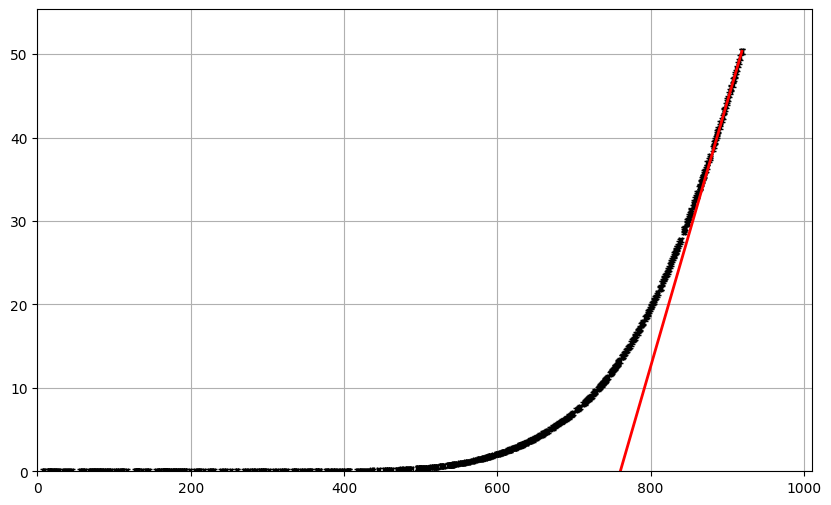

,a,b,u(a),u(b),R^2
0,0.31748,-241.414823,0.008968,8.193124,0.993657


In [283]:
df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = compute_uncertainties(df)

U_sample, I_sample = df["U"][-10:], df["I"][-10:]
model = sm.OLS(I_sample, sm.add_constant(U_sample)).fit()

X_pred = np.linspace(0, U_sample.max(), 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)


fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0, 1.1 * U_sample.max())
ax.set_ylim(0, 1.1 * I_sample.max())

ax.errorbar(
    df["U"],
    df["I"],
    xerr=df["u(U)"],
    yerr=df["u(I)"],
    color="black",
    fmt=".",
    capsize=2,
    markersize=0,
)
plt.plot(X_pred, y_pred, "r-", linewidth=2)
ax.grid()
plt.show()

display(linear_regression_rundown(model))

## Logarithmic scale

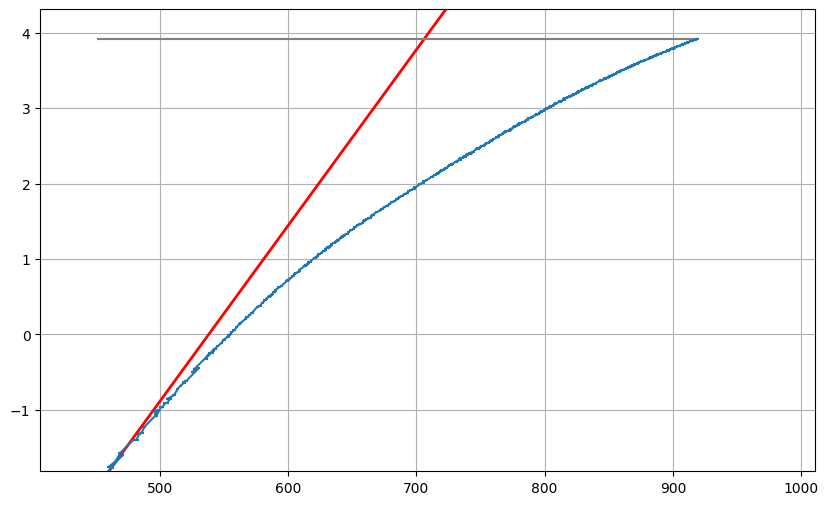

,a,b,u(a),u(b),R^2
0,0.023323,-12.551362,0.001436,0.66453,0.970564


In [284]:
def predicate(row):
    return row["U"] > 450


df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = df.loc[df.apply(predicate, axis=1)]
df = compute_uncertainties(df)


U_sample, I_sample = df["U"][0:10], df["ln(I)"][0:10]
model = sm.OLS(I_sample, sm.add_constant(U_sample)).fit()

X_pred = np.linspace(0, df["U"].max(), 20)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0.9 * df["U"].min(), 1.1 * df["U"].max())
ax.set_ylim(0.9 * df["ln(I)"].min(), 1.1 * df["ln(I)"].max())

ax.errorbar(df["U"], df["ln(I)"], xerr=df["u(U)"])
plt.plot(X_pred, y_pred, "r-", linewidth=2)

x_seq = np.linspace(df["U"].min(), df["U"].max(), 100)
y_seq = np.zeros_like(x_seq) + df["ln(I)"].max()
plt.plot(x_seq, y_seq, color="gray")

ax.grid()
plt.show()

display(linear_regression_rundown(model))

# Illuminated photodiode

In [285]:
ILLUMINATED_PHOTODIODES_DATAFRAMES = [
    pd.read_csv(path, delimiter=";")
    for path in [
        "data/7mA.csv",
        "data/13mA.csv",
        "data/19mA.csv",
        "data/25mA.csv",
        "data/31mA.csv",
        "data/38mA.csv",
    ]
]

ILLUMINATED_PHOTODIODES_LED_CURRENT = np.array([7, 13, 19, 25, 31, 38])


def compute_short_circuit_currents() -> pd.DataFrame:
    shorting_currents = [
        df["I"][0:10].min() + 0.1 for df in ILLUMINATED_PHOTODIODES_DATAFRAMES
    ]
    return [
        df.iloc[(df["I"] - current).abs().idxmin()]
        for current, df in zip(shorting_currents, ILLUMINATED_PHOTODIODES_DATAFRAMES)
    ]

,a,b,u(a),u(b),R^2
0,0.006536,-2.783869,0.000129,0.047065,0.998452


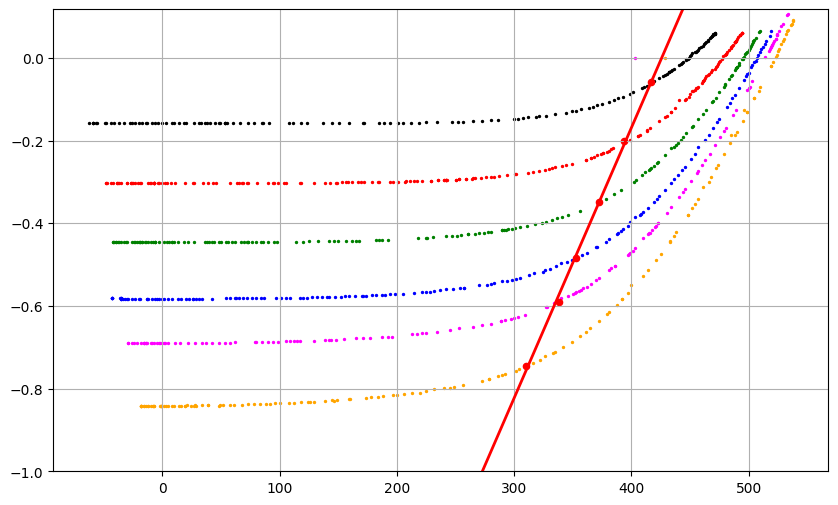

In [286]:
short_circuit_currents = compute_short_circuit_currents()

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_ylim(-1, 1.1 * max([df["I"].max() for df in ILLUMINATED_PHOTODIODES_DATAFRAMES]))

for df, color in zip(
    ILLUMINATED_PHOTODIODES_DATAFRAMES,
    ["black", "red", "green", "blue", "magenta", "orange"],
):
    plt.scatter(df["U"], df["I"], color=color, s=2)

for shorted_current in short_circuit_currents:
    plt.scatter(shorted_current["U"], shorted_current["I"], color="red", s=20)


currents = [df["I"] for df in short_circuit_currents]
voltages = [df["U"] for df in short_circuit_currents]
model = sm.OLS(currents, sm.add_constant(voltages)).fit()
X_pred = np.linspace(0, max(voltages) + 100, 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

plt.plot(X_pred, y_pred, "r-", linewidth=2)

plt.grid()


display(linear_regression_rundown(model))

#### $I_{Z} = f(I_{LED})$ characteristic

,a,b,u(a),u(b),R^2
0,-0.02199,0.082777,0.000538,0.013195,0.997611


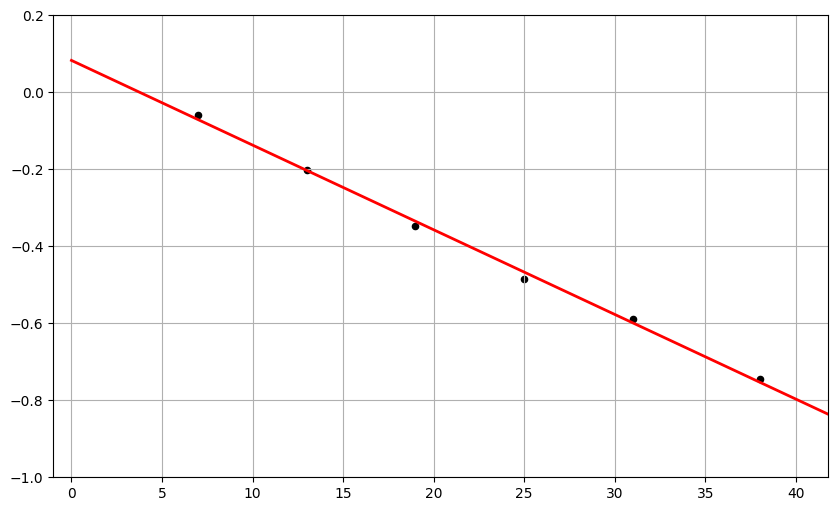

In [309]:
short_circuit_currents = compute_short_circuit_currents()

shorting_currents = [df["I"] for df in short_circuit_currents]
model = sm.OLS(
    shorting_currents, sm.add_constant(ILLUMINATED_PHOTODIODES_LED_CURRENT)
).fit()
X_pred = np.linspace(0, max(ILLUMINATED_PHOTODIODES_LED_CURRENT) + 100, 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-1, 1.1 * max(ILLUMINATED_PHOTODIODES_LED_CURRENT))
ax.set_ylim(-1, 0.2)

for shorting_current, led_current in zip(
    short_circuit_currents, ILLUMINATED_PHOTODIODES_LED_CURRENT
):
    ax.scatter(led_current, shorting_current["I"], color="black", s=20)

ax.plot(X_pred, y_pred, "r-", linewidth=2)
ax.grid()

display(linear_regression_rundown(model))

#### $U_{R} = f(I_{LED})$ characteristic

7 449.0 -0.0006900000153109
13 477.0 -0.0039200000464916
19 495.0 -0.0014700000174343
25 507.0 0.0002800000074785
31 403.0 0.0
38 429.0 0.0


/Users/igorkrzywda/opt/anaconda3/envs/data/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


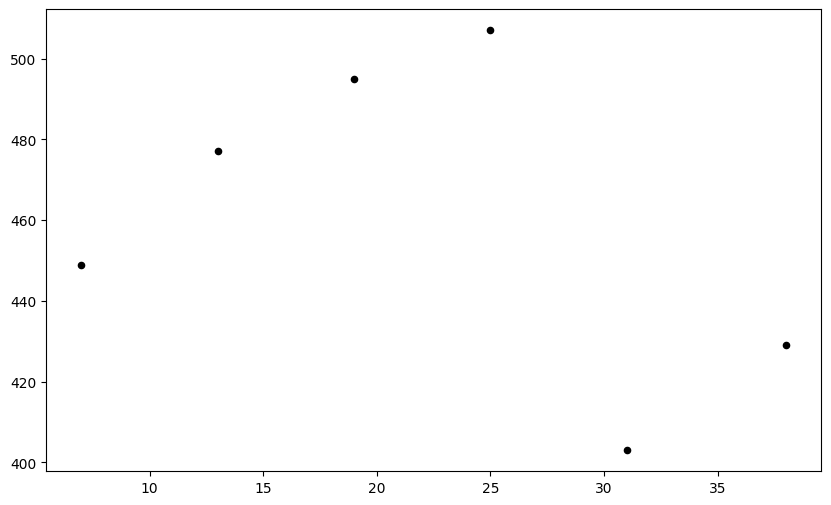

In [320]:
ur = [df.iloc[(df["I"]).abs().idxmin()] for df in ILLUMINATED_PHOTODIODES_DATAFRAMES]

currents = [df["I"] for df in ur]
voltages = [df["U"] for df in ur]
model = sm.Logit(currents, sm.add_constant(voltages)).fit()
X_pred = np.linspace(0, max(voltages) + 100, 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

model.summary()

fig, ax = plt.subplots(figsize=(10, 6))

# plt.plot(X_pred, y_pred, "r-", linewidth=2)

for df, iled in zip(ur, ILLUMINATED_PHOTODIODES_LED_CURRENT):
    print(iled, df["U"], df["I"])
    plt.scatter(iled, df["U"], color="black", s=20)